In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#import xlsxwriter

import sys
#path_support = r'D:\Environments\roulette\Utils\\'  # Directory to support files
#sys.path.append(path_support)
#import roulette_setup as rs

In [ ]:
print("More Changes")

In [3]:
# Adding a block to see how this affects the original file

In [44]:
# Function block

def oe_colors(num):
    # If number is even...
    if num % 2 == 0:
        oe = "even"
        # When is it black?
        if (num <= 10) | ((19 < num) & (num <= 28)):   # Even Black: <10 or 20-28
            col = "black"
        else:                                           # Even Red: 11 - 19
            col = "red"
    # If number is odd...
    else:
        oe = "odd"
        # When is it black?
        if ((11 <= num) & (num < 18)) | (29 <= num):
            col = "black"
        else:
            col = "red"
    return oe,col
            
def halves(num):
    if num < 19:
        val = 1   # 1 - 18           
    else:
        val = 2   # 19 - 36        
    return val

def thirds(num):
    if num < 13:
        val = 1
    elif num < 25:
        val = 2
    else:
        val = 3
    return val

def columns(num):
    # Modulo: when numerator < denominator, quotient is always zero with numerator left over!!
    mod = num % 3
    if mod == 0:
        val = 3
    elif mod == 1:
        val = 1
    else:
        val = 2
    return val
 
def pre_spin():
    if len(history) > 0:
        print("History",[board.loc[x,"label"] for x in history])
    print()
    print("Pre-Spin Data")
    wager_list.append(wager)
    print(f"Units Wagered:\t{wager}")
    print()   
          
def spin_wheel():
    outcome = np.random.randint(0,38)   # Returns a number within 0 - 37...37 being '00'
    history.insert(0,outcome)           # Adds value to first position of the list, rather than append
    win_df = board.loc[outcome]         # Returns row of attributes for outcome
    return win_df
    
def streak_calculator(list_of_results):
    global streak,min_str,max_str,wager,cum_loss
    if 'W' in list_of_results:
        if streak < 0:
            streak = 1
            cum_loss = 0
            set_wager()
        else:
            streak += 1
        if streak > max_str:
            max_str = streak
    else:        
        cum_loss += wager
        if streak > 0:
            streak = -1       
        else:
            streak += -1
        if streak < min_str:
            min_str = streak
        wager = 2 * cum_loss
            
def set_wager():
    global wager
    wager = 0
    for key in bets_dict.keys():
        wager += bets_dict[key]["units"]
    return wager
             
               

In [10]:
# Create table setup dictionary
master_dict = {}

for num in range(0,38):
    # Instantiation
    master_dict[num] = {"label":f"{num}",
                        "oe":"NA",
                        "color":"green",
                        "half":0,
                        "third":0,
                        "column":0,
                        }
    # Convert 37 to 00
    if num == 37:
        master_dict[num]["label"] = "00"
    
    # Dictionary defaults are for 0 & 00
    if (num > 0) & (num < 37):             # 1 - 36
        # Odd/even and Color, green is default so only 1 - 36
        master_dict[num]["oe"] = oe_colors(num)[0]        
        master_dict[num]["color"] = oe_colors(num)[1] 
        
        # Halves               
        master_dict[num]["half"] = halves(num)   
        
        # Thirds
        master_dict[num]["third"] = thirds(num)        
        
        # Column
        master_dict[num]["column"] = columns(num) 
        
# Wheel order
order_string = "0-28-9-26-30-11-7-20-32-17-5-22-34-15-3-24-36-13-1-00-27-10-25-29-12-8-19-31-18-6-21-33-16-4-23-35-14-2"
order_list = order_string.split("-")
order_dict = {}

for i,num in enumerate(order_list):
    if num == '00':
        num = '37'
    order_dict[int(num)] = i+1
    
# Create df
board = pd.DataFrame(master_dict).T

# Adding order to board df
board["order"] = pd.Series(order_dict)  # Use instead of map when df index is the link

# Payout schedule
payout_dict = {"label":35,'oe':1,'color':1,'half':1,'third':2,'column':2}


In [47]:
##### Gameplay
# xlsx setup
wb = xlsxwriter.Workbook("..\\RouletteAnalysis.xlsx")
standard_play = wb.add_worksheet("Standard")
standard_play.freeze_panes(1,0)
standard_play.write_row(0,0,['Visit',
                             'Spins',
                             'Units Wagered',
                             'Final Units',
                             'Max Units',
                             'Min Units',
                             'Max Streak',
                             'Min Streak'])

# Bets
# Amount = units of bet, not actual dollar values
bets_dict = {1:{"bet":"column","value":1,"units":1},
             2:{"bet":"column","value":2,"units":1}}

# Wager
wager = set_wager()         # Aggregation of all bet

visits = 25                 # Trips to casino
spins_per_visit = 120       # Two hours of play, one minute per outcome
for j in range(visits):
    j = j +1
    # Visit-level data
    bankroll = 0    # Bankroll tracks units won/lost throughout a casino visit
    max_br = 0      # Highest amount of units accumulated
    min_br = 0      # Lowest amount of units accumulated
    streak = 0      # Tracks consecutive wins or losses
    max_str = 0     # Highest amount of consecutive wins
    min_str = 0     # Highest amount of consecutive losses
    cum_loss = 0    # Tracks wagers lost, wager becomes 2 * this value during losing streak
    history = []    # Stores outcomes
    wager_list = []
      
    # Pre-spin data
    #pre_spin()

    # Wheel spins...       
    for i in range(spins_per_visit):    # Number of spins
        bankroll += -wager              # Deduct wager prior to each spin
        df = spin_wheel()               # Spin occurs
        
        list_of_results = []
        for bet_num in bets_dict.keys():
            
            bet = bets_dict[bet_num]["bet"]
            val = bets_dict[bet_num]["value"]
            result = df.loc[bet]

            if val == result:
                win_lose = "W"          
                scalar = payout_dict[bet]
                bet_amt = bets_dict[bet_num]["units"]
                win = (.5 * wager) * scalar         # This is a band-aid, assumes all multi-bets are equal
                bankroll += (win + (.5 * wager))    # Ditto

            else:
                win_lose = "L"
               
            list_of_results.append(win_lose)    # For streak calculation

            if len(list_of_results) == len(bets_dict.keys()):
                streak_calculator(list_of_results)
            if bankroll > max_br:
                max_br = bankroll
            if bankroll < min_br:
                min_br = bankroll

    standard_play.write_row(j,0,[j,
                                 spins_per_visit,
                                 wager,
                                 bankroll,
                                 max_br,
                                 min_br,
                                 max_str,
                                 abs(min_str)])

wb.close()

1 0 4
1 1 2
1 2 4
1 3 2
1 4 4
1 5 2
1 6 2
1 7 4
1 8 2
1 9 4
1 10 12
1 11 2
1 12 2
1 13 2
1 14 4
1 15 2
1 16 2
1 17 2
1 18 4
1 19 12
1 20 36
1 21 108
1 22 2
1 23 2
1 24 2
1 25 2
1 26 2
1 27 4
1 28 12
1 29 36
1 30 2
1 31 4
1 32 12
1 33 2
1 34 4
1 35 2
1 36 4
1 37 12
1 38 2
1 39 2
1 40 2
1 41 4
1 42 2
1 43 2
1 44 2
1 45 4
1 46 2
1 47 4
1 48 12
1 49 2
1 50 4
1 51 2
1 52 2
1 53 2
1 54 4
1 55 2
1 56 4
1 57 12
1 58 36
1 59 2
1 60 2
1 61 2
1 62 2
1 63 4
1 64 12
1 65 36
1 66 108
1 67 2
1 68 2
1 69 2
1 70 4
1 71 2
1 72 2
1 73 4
1 74 2
1 75 2
1 76 2
1 77 2
1 78 2
1 79 2
1 80 2
1 81 2
1 82 2
1 83 2
1 84 2
1 85 2
1 86 2
1 87 2
1 88 4
1 89 2
1 90 4
1 91 2
1 92 2
1 93 4
1 94 2
1 95 4
1 96 12
1 97 36
1 98 108
1 99 324
1 100 2
1 101 2
1 102 2
1 103 2
1 104 2
1 105 4
1 106 12
1 107 2
1 108 4
1 109 2
1 110 2
1 111 2
1 112 4
1 113 2
1 114 2
1 115 2
1 116 2
1 117 4
1 118 12
1 119 36
2 0 72
2 1 216
2 2 648
2 3 2
2 4 2
2 5 2
2 6 2
2 7 2
2 8 2
2 9 2
2 10 4
2 11 2
2 12 2
2 13 2
2 14 2
2 15 4
2 16 12
2 17 36
2 

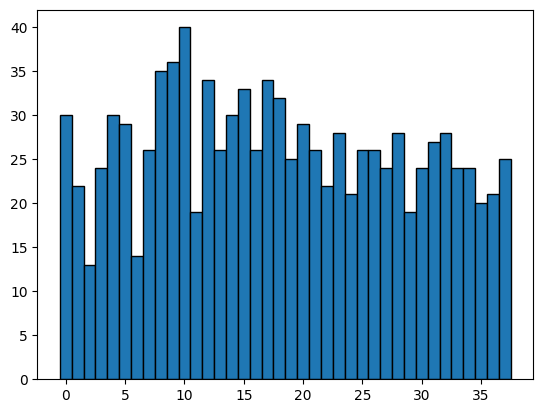

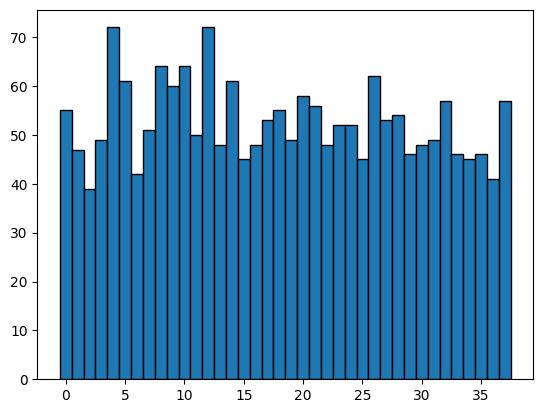

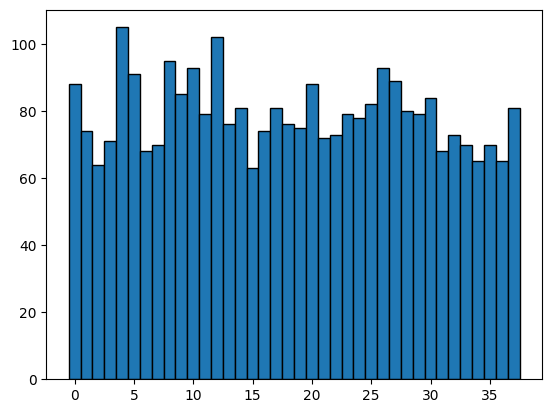

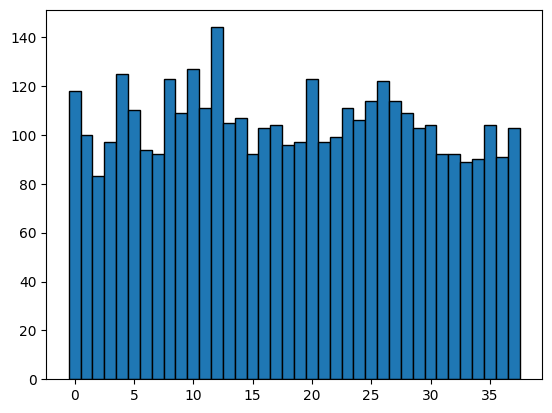

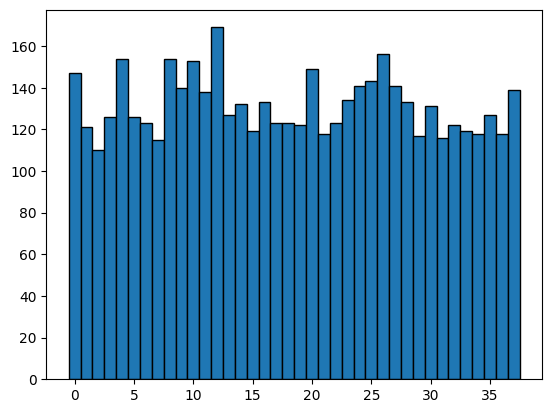

In [64]:
# Evaluate RNG

all_oc = []
for i in range(5):
    outcomes = [np.random.randint(0,38) for i in range(1000)]
    all_oc = outcomes + all_oc
    bins = np.linspace(0,38,num=39)
    plt.hist(all_oc,bins=bins,edgecolor="black",align="left")
    plt.show()